### Training Parameterized Quantum Circuits

In [1]:
#Training Parameterized Quantum Circuits
from qiskit.circuit.library import RealAmplitudes

In [2]:
anstaz = RealAmplitudes(num_qubits=2, reps=1, insert_barriers=True).decompose()

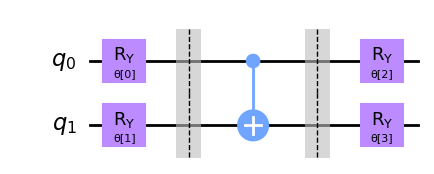

In [3]:
anstaz.draw('mpl')

#### __Finite Difference Gradient__

In [4]:
from qiskit.opflow import Z, I

hamiltonian = Z ^ Z

In [5]:
from qiskit.opflow import StateFn, PauliExpectation

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(anstaz)
pauli_expectation = PauliExpectation().convert(expectation)

In [6]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import CircuitSampler

import numpy as np

quantum_instance = QuantumInstance(
    Aer.get_backend(
        'qasm_simulator',
        shots = 8192, 
        seed_simulator = 2718,
        seed_transpiler = 2718
    )
)

sampler = CircuitSampler(quantum_instance)

In [7]:
def evaluate_expectation(theta):
    value_dict = dict(zip(anstaz.parameters, theta))
    result = sampler.convert(pauli_expectation, params=value_dict).eval()
    return np.real(result)

In [8]:
point = np.random.random(anstaz.num_parameters)
INDEX = 2

In [9]:
EPS = 0.2

e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

In [10]:
final_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(final_difference)

0.13671875000000028


Doing what's above using `Gradient`

In [11]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)
grad = shifter.convert(expectation, params=anstaz.parameters[INDEX])
print(grad)

value_dict = dict(zip(anstaz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐ ░       ░ ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├─░───■───░─┤ Ry(θ[2] + 0.2) ├
         ├──────────┤ ░ ┌─┴─┐ ░ └──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├─░─┤ X ├─░────┤ Ry(θ[3]) ├───
         └──────────┘ ░ └───┘ ░    └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐ ░       ░ ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├─░───■───░─┤ Ry(θ[2] - 0.2) ├
         ├──────────┤ ░ ┌─┴─┐ ░ └──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├─░─┤ X ├─░────┤ Ry(θ[3]) ├───
         └──────────┘ ░ └───┘ ░    └──────────┘   
    )
  ])
])


0.07812500000000011

#### __Analytic Gradient__

Using `Gradient`

In [12]:
shift = Gradient() #parameter shifter by default
gradient = shift.convert(expectation, params=anstaz.parameters[INDEX])
sampler.convert(gradient, value_dict).eval().real

-0.009765625000000056

In [13]:
point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

In [14]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

In [15]:
def evaluate_gradient(theta):
    value_dict = dict(zip(anstaz.parameters, theta))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()
    return np.real(result)

In [16]:
class OptimerLog:
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        self.loss.append(ftheta)

In [17]:
from qiskit.algorithms.optimizers import GradientDescent

gd_log = OptimerLog()
gd = GradientDescent(
    maxiter=300,
    learning_rate=0.01,
    callback=gd_log.update
)

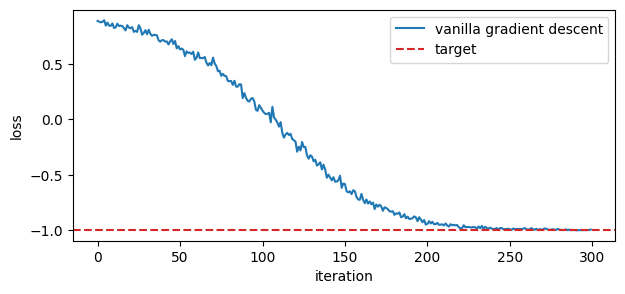

In [18]:
result = gd.minimize(
    fun=evaluate_expectation,
    x0=point,
    jac=evaluate_gradient
)

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, label="vanilla gradient descent")
plt.axhline(-1, ls="--", c="C3", label="target")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()

#### __Natural Gradient__

In [19]:
from qiskit.opflow import NaturalGradient


natural_gradient = NaturalGradient(regularization='ridge').convert(expectation)
natural_gradient_in_pauli_basis = PauliExpectation().convert(natural_gradient)
sampler = CircuitSampler(quantum_instance, caching='all')

def evaluate_natural_gradient(theta):
    value_dict = dict(zip(anstaz.parameters, theta))
    result = sampler.convert(natural_gradient, params=value_dict).eval()
    return np.real(result)

print("Vanilla Gradient: ", evaluate_gradient(point))
print("Natural Gradient: ", evaluate_natural_gradient(point))

Vanilla Gradient:  [ 0.13769531 -0.32714844 -0.26171875 -0.15625   ]
Natural Gradient:  [ 0.88981261 -0.45298045 -0.4058795  -0.16533439]


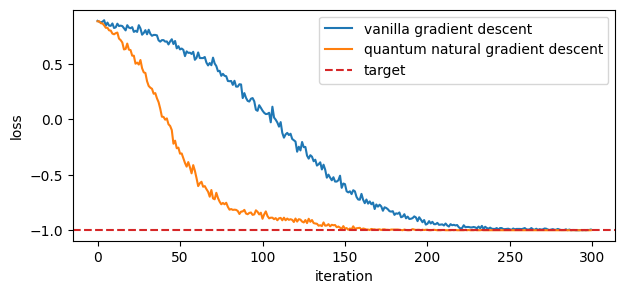

In [20]:
#Quantum Natural Gradient
qng_log = OptimerLog()
qng = GradientDescent(
    maxiter=300,
    learning_rate=0.01,
    callback=qng_log.update
)

qng_result = qng.minimize (
    evaluate_expectation,
    point,
    evaluate_natural_gradient
)

plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, c="C0", label="vanilla gradient descent")
plt.plot(qng_log.loss, c="C1", label="quantum natural gradient descent")
plt.axhline(-1, ls="--", c="C3", label="target")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()

Using `SPSA` (Simultaneous Perturbation Stochastic Approximation) updating the circuit parameter using the approximate gradient of the loss function using random sampling.

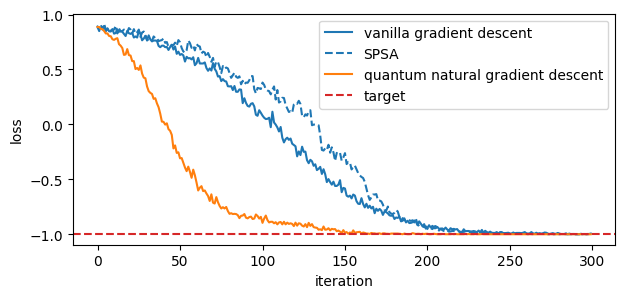

In [21]:
from qiskit.algorithms.optimizers import SPSA

spsa_log = OptimerLog()
spsa = SPSA(
    maxiter=300,
    learning_rate=0.01,
    perturbation=0.01,
    callback=spsa_log.update
)

spsa_result = spsa.minimize(
    evaluate_expectation,
    point
)

plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, c="C0", label="vanilla gradient descent")
plt.plot(spsa_log.loss, c="C0", ls="--", label="SPSA")
plt.plot(qng_log.loss, c="C1", label="quantum natural gradient descent")
plt.axhline(-1, ls="--", c="C3", label="target")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()

Using `QNSPSA` (Quantum Natural - Simultaneous Perturbation Stochastic Approximation) updating the circuit parameter using the quantum natural gradient of the loss function using random sampling.

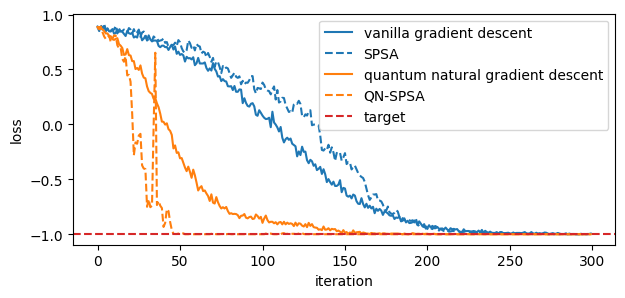

In [22]:
from qiskit.algorithms.optimizers import QNSPSA

qnspsa_log = OptimerLog()
fidelity = QNSPSA.get_fidelity(anstaz, quantum_instance, expectation=PauliExpectation())
qnspsa = QNSPSA(
    fidelity=fidelity,
    maxiter=300,
    learning_rate=0.01,
    perturbation=0.01,
    callback=qnspsa_log.update
)

result = qnspsa.minimize(
    evaluate_expectation,
    point
)

plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, c="C0", label="vanilla gradient descent")
plt.plot(spsa_log.loss, c="C0", ls="--", label="SPSA")
plt.plot(qng_log.loss, c="C1", label="quantum natural gradient descent")
plt.plot(qnspsa_log.loss, c="C1", ls="--", label="QN-SPSA")
plt.axhline(-1, ls="--", c="C3", label="target")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()

### Training Parameterized Circuits In Practice

In practice, people often resort to using `SPSA`. To improve convergence, we don't use a constant learning rate, but an exponentially decreasing one.

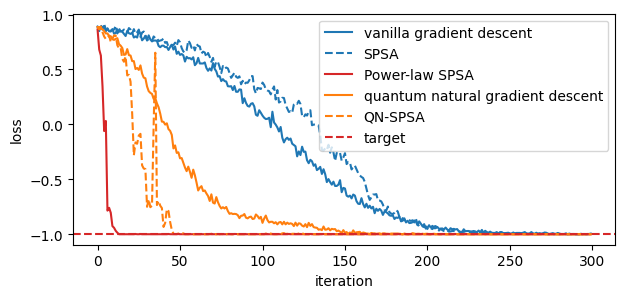

In [23]:
autospsa_log = OptimerLog()
autospsa = SPSA(
    maxiter=300,
    learning_rate=None,
    perturbation=None,
    callback=autospsa_log.update
)

result = autospsa.minimize(evaluate_expectation, point)

plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, c="C0", label="vanilla gradient descent")
plt.plot(spsa_log.loss, c="C0", ls="--", label="SPSA")
plt.plot(autospsa_log.loss, c="C3", label="Power-law SPSA")
plt.plot(qng_log.loss, c="C1", label="quantum natural gradient descent")
plt.plot(qnspsa_log.loss, c="C1", ls="--", label="QN-SPSA")
plt.axhline(-1, ls="--", c="C3", label="target")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()